In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import time
import os
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg

In [2]:
# Set random seed for reproducibility
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda


In [5]:
# Hyperparameters
LEARNING_RATE = 5e-5
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3  
NOISE_DIM = 100
NUM_EPOCHS = 40
FEATURES_DISC = 64 
FEATURES_GEN = 64 
BETA = 0.5

# Create directories for saving results and models
os.makedirs('Results', exist_ok=True)
os.makedirs('Models', exist_ok=True)

In [6]:
# Load CIFAR10 dataset
dataset = datasets.CIFAR10(
    root="./dataset/CIFAR10data", download=True,
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Files already downloaded and verified


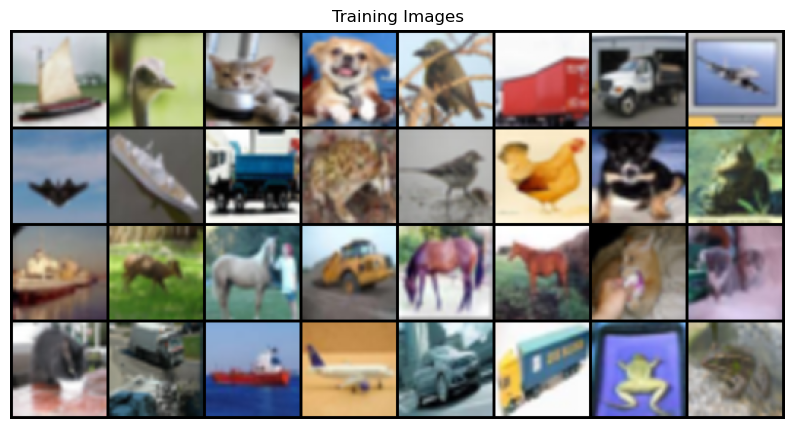

In [7]:
# Display a batch of real images
real_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [8]:
# Define the Discriminator model
class DiscriminatorModel(nn.Module):
    def __init__(self, channels_img, features_d):
        super(DiscriminatorModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.model(x)

In [9]:
# Define the Generator model
class GeneratorModel(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(GeneratorModel, self).__init__()
        self.model = nn.Sequential(
            self._block(channels_noise, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.model(x)

In [10]:
# Initialize weights for the models
def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [11]:
# Create instances of the Generator and Discriminator
generator = GeneratorModel(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
discriminator = DiscriminatorModel(CHANNELS_IMG, FEATURES_DISC).to(device)
init_weights(generator)
init_weights(discriminator)

In [12]:
# Set up optimizers and loss function
optimizer_gen = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA, 0.999))
optimizer_disc = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA, 0.999))
loss_function = nn.BCELoss()
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)  # Fixed noise for generating images
iterations = 0

In [13]:
# Define the InceptionV3 model for FID calculation
class InceptionV3Model(nn.Module):
    DEFAULT_BLOCK_INDEX = 3
    BLOCK_INDEX_BY_DIM = {
        64: 0,
        192: 1,
        768: 2,
        2048: 3
    }

    def __init__(self, output_blocks=[DEFAULT_BLOCK_INDEX], resize_input=True, normalize_input=True, requires_grad=False):
        super(InceptionV3Model, self).__init__()
        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, 'Last possible output block index is 3'

        self.blocks = nn.ModuleList()
        inception = models.inception_v3(pretrained=True)

        # Define the blocks of the Inception model
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        output = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                output.append(x)

            if idx == self.last_needed_block:
                break

        return output

In [14]:
# Initialize the Inception model
block_idx = InceptionV3Model.BLOCK_INDEX_BY_DIM[2048]
fid_model = InceptionV3Model([block_idx]).to(device)

# Function to calculate activation statistics
def compute_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    model.eval()
    activations = np.empty((len(images), dims))

    if cuda:
        batch = images.cuda()
    else:
        batch = images
    pred = model(batch)[0]
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = F.adaptive_avg_pool2d(pred, output_size=(1, 1))

    activations = pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mean = np.mean(activations, axis=0)
    covariance = np.cov(activations, rowvar=False)
    return mean, covariance

/home/agolla/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/agolla/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
# Function to calculate Frechet distance
def compute_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, 'Mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, 'Covariance matrices have different dimensions'

    diff = mu1 - mu2

    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('FID calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    trace_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * trace_covmean)

In [16]:
# Function to calculate FID score
def compute_fid(images_real, images_fake, model):
    mu1, sigma1 = compute_activation_statistics(images_real, model, cuda=True)
    mu2, sigma2 = compute_activation_statistics(images_fake, model, cuda=True)
    fid_value = compute_frechet_distance(mu1, sigma1, mu2, sigma2)
    return fid_value

In [17]:
# Training loop
generator_loss = []
discriminator_loss = []
image_list = []
fid_scores = []
iterations = 0

print("Training has begun!")
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    epoch += 1

    for batch_idx, data in enumerate(dataloader):
        real_images = data[0].to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake_images = generator(noise)

        # Train Discriminator
        disc_real = discriminator(real_images).reshape(-1)
        loss_disc_real = loss_function(disc_real, torch.ones_like(disc_real))
        disc_fake = discriminator(fake_images.detach()).reshape(-1)
        loss_disc_fake = loss_function(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        discriminator.zero_grad()
        loss_disc.backward()
        optimizer_disc.step()

        # Train Generator
        output = discriminator(fake_images).reshape(-1)
        loss_gen = loss_function(output, torch.ones_like(output))
        generator.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()
        generator_loss.append(loss_gen.detach().cpu())
        discriminator_loss.append(loss_disc.detach().cpu())

        # Save generated images for evaluation
        if (iterations % 500 == 0) or ((epoch == NUM_EPOCHS) and (batch_idx == len(dataloader) - 1)):
            with torch.no_grad():
                fake_images = generator(fixed_noise).detach().cpu()
            image_list.append(utils.make_grid(fake_images, padding=2, normalize=True))

        iterations += 1

    # Calculate FID score
    fid_distance = compute_fid(real_images, fake_images, fid_model)
    fid_scores.append(fid_distance)

    if epoch % 5 == 0:
        print(f'Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} '
              f'Loss Discriminator: {loss_disc:.3f}, Loss Generator: {loss_gen:.3f}, FID: {fid_distance:.3f}')

    # Save generated and real images
    generated_images = generator(fixed_noise)
    os.makedirs('Results/DCGAN_FAKE', exist_ok=True)
    os.makedirs('Results/DCGAN_REAL', exist_ok=True)
    utils.save_image(generated_images.detach(), f'Results/DCGAN_FAKE/DCGAN_epoch_{epoch:03d}.png', normalize=True)
    utils.save_image(real_images.detach(), f'Results/DCGAN_REAL/DCGAN_epoch_{epoch:03d}.png', normalize=True)

end_time = time.time()
print(f'Training completed in: {end_time - start_time:.2f} seconds')

Training has begun!
Epoch [5/40] Batch 390/391 Loss Discriminator: 0.511, Loss Generator: 1.028, FID: 426.288
Epoch [10/40] Batch 390/391 Loss Discriminator: 0.646, Loss Generator: 0.916, FID: 302.186
Epoch [15/40] Batch 390/391 Loss Discriminator: 0.590, Loss Generator: 0.962, FID: 276.367
Epoch [20/40] Batch 390/391 Loss Discriminator: 0.670, Loss Generator: 0.716, FID: 249.356
Epoch [25/40] Batch 390/391 Loss Discriminator: 0.602, Loss Generator: 0.870, FID: 227.707
Epoch [30/40] Batch 390/391 Loss Discriminator: 0.627, Loss Generator: 0.881, FID: 213.407
Epoch [35/40] Batch 390/391 Loss Discriminator: 0.613, Loss Generator: 0.763, FID: 207.719
Epoch [40/40] Batch 390/391 Loss Discriminator: 0.658, Loss Generator: 0.659, FID: 226.806
Training completed in: 1739.12 seconds


In [18]:
# Save loss data
os.makedirs('Results/Loss_Data', exist_ok=True)
np.save('Results/Loss_Data/DCGAN_Generator_Loss', generator_loss) 
np.save('Results/Loss_Data/DCGAN_Discriminator_Loss', discriminator_loss) 

In [19]:
# Load loss data for plotting
generator_loss = np.load('Results/Loss_Data/DCGAN_Generator_Loss.npy')
discriminator_loss = np.load('Results/Loss_Data/DCGAN_Discriminator_Loss.npy')

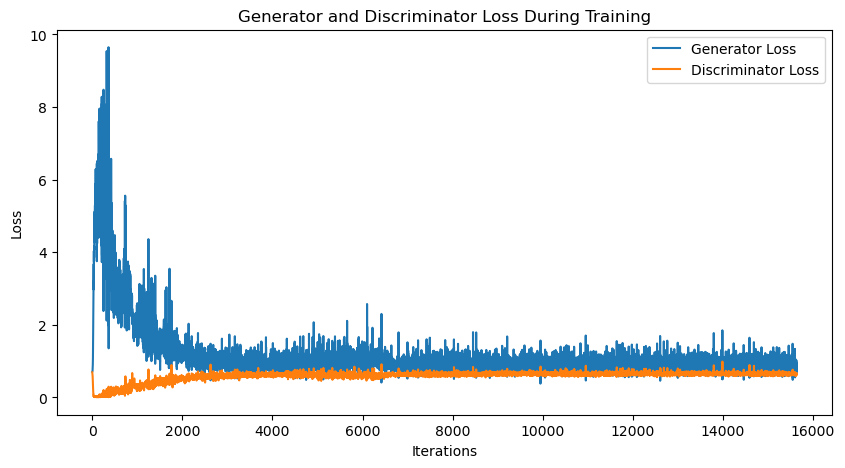

In [20]:
# Plot generator and discriminator loss
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_loss, label="Generator Loss")
plt.plot(discriminator_loss, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Results/loss_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()

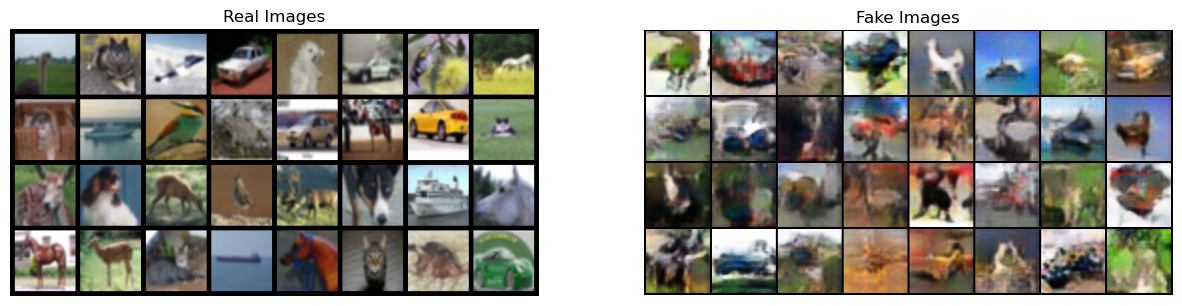

In [21]:
# Plot real and fake images
real_batch = next(iter(dataloader))
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(), (1, 2, 0)))
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(image_list[-1], (1, 2, 0)))
plt.savefig('Results/DCGAN_Best_Fake_Images.pdf', format='pdf', bbox_inches='tight')
plt.show()

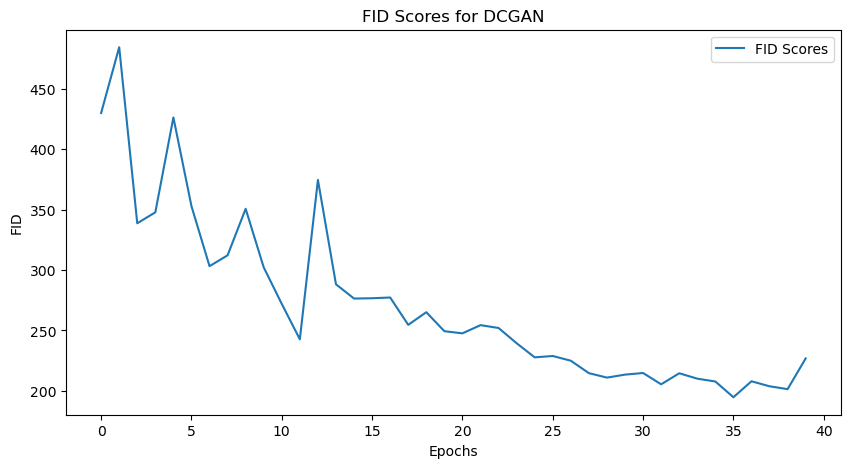

In [22]:
# Plot FID scores
plt.figure(figsize=(10, 5))
plt.title("FID Scores for DCGAN")
plt.plot(fid_scores, label="FID Scores")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.savefig('Results/FID_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [23]:
# Save FID scores
os.makedirs('Results/FID_scores', exist_ok=True)
np.save('Results/FID_scores/DCGAN_FID', fid_scores)

In [24]:
# Summary statistics
mean_gen_loss = np.mean(generator_loss)
mean_disc_loss = np.mean(discriminator_loss)
min_gen_loss = np.min(generator_loss)
min_disc_loss = np.min(discriminator_loss)
last_gen_loss = generator_loss[-1]
last_disc_loss = discriminator_loss[-1]

In [25]:
mean_fid = np.mean(fid_scores)
min_fid = np.min(fid_scores)
max_fid = np.max(fid_scores)
last_fid = fid_scores[-1]

(mean_gen_loss, mean_disc_loss, min_gen_loss, min_disc_loss, last_gen_loss, last_disc_loss, min_fid, max_fid, mean_fid, last_fid)

(1.1384691,
 0.5839838,
 0.3800797,
 0.0051995236,
 0.65869576,
 0.65801615,
 194.7039671166755,
 484.4080822966499,
 270.6405019297378,
 226.80632477199367)